In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Load the already prepped data. 
# Note that the prepped data is created in the "Capstone Model_no augmentation" notebook file available at:
# https://github.com/stjoha81/Capstone_2023_2024/blob/main/Capstone%20Model_no%20augmentation.ipynb
# Running the steps up until the train_test_split.
X_array = np.load("capstone_prepped_x.npy")
y_array_encoded = np.load("capstone_prepped_y.npy")

In [3]:
# Set random seed.
seed =123

# Split into train and test data.
# shuffle=True by default but included it in the function call for clarity.
# Use stratify to make sure the same proportion of each label exists in the training and the test data.
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array_encoded, shuffle=True, stratify=y_array_encoded, random_state=seed)

# Split the data into training and validation sets.
# Chose to use only 10% of the training data for validation due to the number of images available.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=seed)


In [4]:
# Look at the shapes of everything:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2203, 256, 256, 3)
y_train shape: (2203, 4)
X_test shape: (816, 256, 256, 3)
y_test shape: (816, 4)
X_val shape: (245, 256, 256, 3)
y_val shape: (245, 4)


In [5]:
# Load the pre-trained VGG16 model (excluding the top classifier)

# base_vgg16_model = VGG16(include_top=False)]
base_vgg16_model = VGG16(include_top=False, input_shape=(256,256,3))
#  input_shape=IMG_SIZE + (3,)
base_vgg16_model.summary()



Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [6]:
# Freeze the layers in the base model

base_vgg16_model.trainable=False
base_vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [7]:
# Now create model for fine tuning and add trainable layers to the base VGG16 model. 

# Define the Keras model
model2_finetuned = Sequential()

# Add the vgg16 model as the base model.
model2_finetuned.add(base_vgg16_model)

# Flatten to get the right shape?
model2_finetuned.add(Flatten())

# Add a dropout layer to prevent overfitting. Set dropout rate to 0.5.
model2_finetuned.add(Dropout(rate=0.5))

# Add a dense layer to get ouput. Chose softmax activation since this is a multiclassification problem.
model2_finetuned.add(Dense(4, activation='softmax'))

# Summarize the model.
model2_finetuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 4)                 131076    
                                                                 
Total params: 14845764 (56.63 MB)
Trainable params: 131076 (512.02 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
# Compile the model.
model2_finetuned.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Use sparse_categorical_crossentropy for loss?
#model2_finetuned.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [9]:
# Create a stop callback and train the model.

# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.
stop_callback = EarlyStopping(monitor="loss", patience=6)

# Train the model
model2_finetuned.fit(x=X_train, y=y_train , validation_data=(X_val, y_val), epochs=100, callbacks=[stop_callback], verbose=2)


Epoch 1/100
69/69 - 109s - loss: 7.7722 - accuracy: 0.7227 - val_loss: 4.1356 - val_accuracy: 0.8245 - 109s/epoch - 2s/step
Epoch 2/100
69/69 - 129s - loss: 2.4975 - accuracy: 0.8856 - val_loss: 3.6821 - val_accuracy: 0.8816 - 129s/epoch - 2s/step
Epoch 3/100
69/69 - 131s - loss: 1.2904 - accuracy: 0.9324 - val_loss: 4.8263 - val_accuracy: 0.8694 - 131s/epoch - 2s/step
Epoch 4/100
69/69 - 131s - loss: 1.0032 - accuracy: 0.9433 - val_loss: 3.7184 - val_accuracy: 0.8898 - 131s/epoch - 2s/step
Epoch 5/100
69/69 - 148s - loss: 1.2185 - accuracy: 0.9501 - val_loss: 4.0767 - val_accuracy: 0.8776 - 148s/epoch - 2s/step
Epoch 6/100
69/69 - 137s - loss: 0.6556 - accuracy: 0.9641 - val_loss: 4.0020 - val_accuracy: 0.8939 - 137s/epoch - 2s/step
Epoch 7/100
69/69 - 130s - loss: 0.8132 - accuracy: 0.9573 - val_loss: 7.5992 - val_accuracy: 0.8571 - 130s/epoch - 2s/step
Epoch 8/100
69/69 - 128s - loss: 0.6779 - accuracy: 0.9705 - val_loss: 4.4345 - val_accuracy: 0.9020 - 128s/epoch - 2s/step
Epoch 9/

In [10]:
# Make predictions on test data
y_predicted = model2_finetuned.predict(X_test)
print("y_predicted shape:", y_predicted.shape)
print("y_test shape:", y_test.shape)

26/26 [==============================] - 32s 1s/step
y_predicted shape: (816, 4)
y_test shape: (816, 4)


In [11]:
# Confusion matrix

# Save a copy of y_test before calling argmax (for development purposes).
#y_test_copy = y_test
#y_test = y_test_copy
# Why need argmax?
# Taken from https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
y_test=np.argmax(y_test, axis=1)
y_predicted=np.argmax(y_predicted, axis=1)
#y_predicted=np.argmax(y_predicted)

finetuned_confusion_matrix = confusion_matrix(y_test, y_predicted)

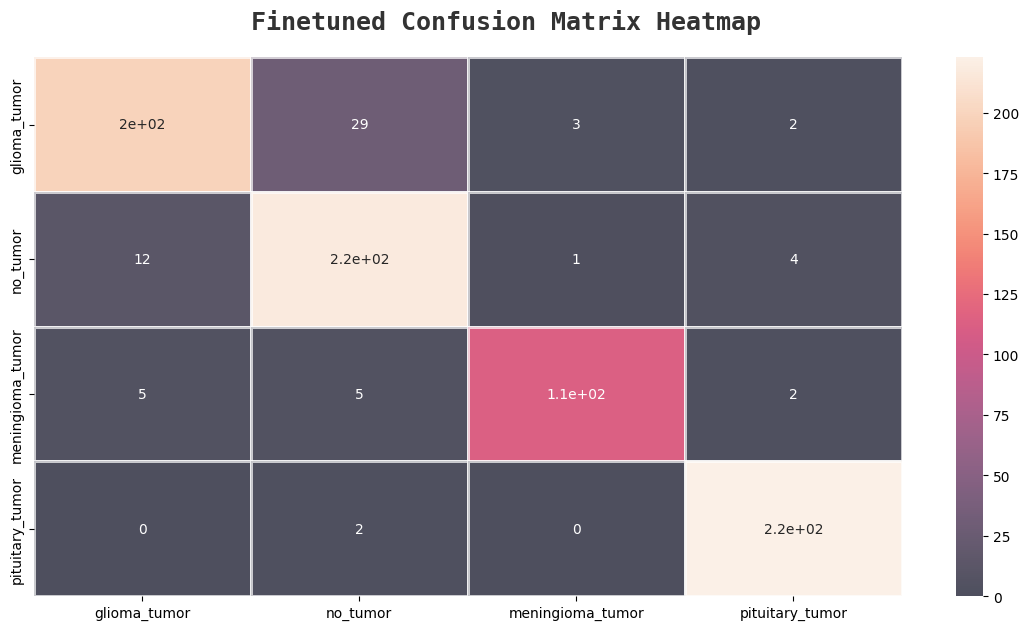

In [17]:
# Plot the confusion matrix as a heatmap.

# Create a 1 x 1 subplot, size (14,7)
fig,ax=plt.subplots(1,1,figsize=(14,7))

# Create labels for the axes.
axis_labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

# Generate a heatmap for the confusion matrix using the labels for each axis, and write the data in each cell.
sns.heatmap(finetuned_confusion_matrix,ax=ax,xticklabels=axis_labels,yticklabels=axis_labels,annot=True, alpha=0.7,linewidths=2)

# Create text for the heatmap.
fig.text(s="Finetuned Confusion Matrix Heatmap",size=18,fontweight="bold", fontname="monospace",y=0.92,x=0.28,alpha=0.8)

# Show the plot of the confusion matrix.
plt.show()

In [18]:
# Classification report.

# 0 - Glioma Tumor
# 1 - No Tumor
# 2 - Meningioma Tumor
# 3 - Pituitary Tumor

finetuned_classification_report = classification_report(y_test,y_predicted)
print(finetuned_classification_report)

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       232
           1       0.86      0.93      0.89       234
           2       0.97      0.90      0.93       125
           3       0.97      0.99      0.98       225

    accuracy                           0.92       816
   macro avg       0.93      0.92      0.92       816
weighted avg       0.92      0.92      0.92       816



In [20]:
# Fine tuned results are much better than cnn results. 
# Both the confusion matrix and classification report show significant improvments in precision, recall, and accuracy for the finetuned model.